This gives an example of the use of the Markov Switching Model that I wrote for the [Statsmodels](https://github.com/statsmodels/statsmodels) Python package, to replicate the treatment of Filardo (1994) as given in Kim and Nelson (1999). This model demonstrates estimation with time-varying transition probabilities.

This is tested against Kim and Nelson's (1999) code (HMT_TVP.OPT), which can be found at [http://econ.korea.ac.kr/~cjkim/SSMARKOV.htm](http://econ.korea.ac.kr/~cjkim/SSMARKOV.htm). It also corresponds to the examples of Markov-switching models from E-views 8, which can be found at [http://www.eviews.com/EViews8/ev8ecswitch_n.html#TimeVary](http://www.eviews.com/EViews8/ev8ecswitch_n.html#TimeVary).

<!-- TEASER_END -->

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.mar_model import MAR

In [2]:
# Filardo's 1994 Industrial Production dataset: Monthly, 1947.1 - 1995.3
import re
f = open('data/filardo.prn')
data = pd.DataFrame(
    [map(float, re.split(' +', line.strip())) for line in f.readlines()[:-1]],
    index=pd.date_range('1948-01-01', '1991-04-01', freq='MS'),
    columns=['month', 'ip', 'idx']
)
data['dlip'] = np.log(data['ip']).diff()*100
# Deflated pre-1960 observations by ratio of std. devs.
# See hmt_tvp.opt or Filardo (1994) p. 302
std_ratio = data['dlip']['1960-01-01':].std() / data['dlip'][:'1959-12-01'].std()
data['dlip'][:'1959-12-01'] = data['dlip'][:'1959-12-01'] * std_ratio

data['dlidx'] = np.log(data['idx']).diff()*100
data['dmdlidx'] = data['dlidx'] - data['dlidx'].mean()

# NBER recessions
from pandas.io.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

In [3]:
# Model Setup
order = 4
nstates = 2

switch_ar = False
switch_var = False
switch_mean = True

In [4]:
mod = MAR(data.dlip[2:], order, nstates,
                    switch_ar=switch_ar, switch_var=switch_var, switch_mean=switch_mean,
                    tvtp_exog=data.dmdlidx[1:])
params = np.array(np.r_[
    [1.64982, -0.99472, -4.35966, -1.77043], # TVTP parameters
    [0.18947, 0.07933, 0.11094,  0.12226],   # AR parameters
    [-np.log(0.69596)],                      # Std. Dev
     [-0.86585, 0.51733]                      # Mean
])

In [5]:
# Filter the data
(
    marginal_densities, filtered_joint_probabilities,
    filtered_joint_probabilities_t1
) = mod.filter(params);

transitions = mod.separate_params(params)[0]

# Smooth the data
filtered_marginal_probabilities = mod.marginalize_probabilities(filtered_joint_probabilities[1:])
smoothed_marginal_probabilities = mod.smooth(filtered_joint_probabilities, filtered_joint_probabilities_t1, transitions)

# Save the data
data['filtered'] = np.r_[
    [np.NaN]*(order+2),
    filtered_marginal_probabilities[:,0]
]

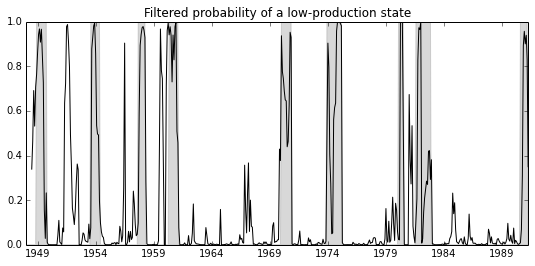

In [6]:
import matplotlib.pyplot as plt
from matplotlib import dates
fig = plt.figure(figsize=(9,4))

ax = fig.add_subplot(111)
ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(data.index, data.filtered, 'k')
ax.set(
    xlim=('1948-01-01', '1991-04-01'),
    ylim=(0,1),
    title='Filtered probability of a low-production state'
);